# Ophalen weersvoorspelling

## Temperatuur



<AxesSubplot:xlabel='Tijdstip'>

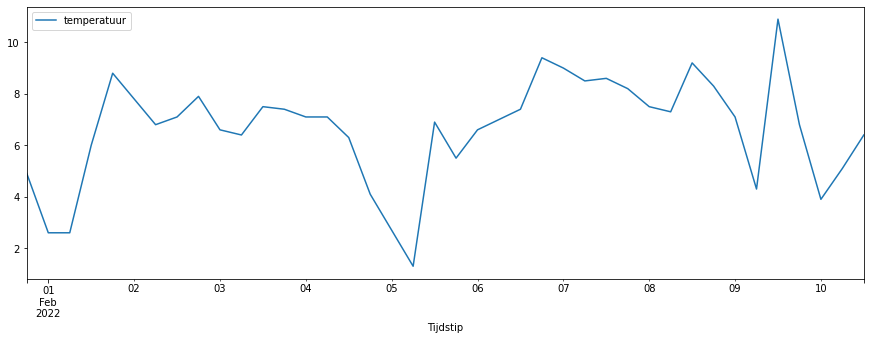

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

url = 'https://cdn.knmi.nl/knmi/json/page/weer/waarschuwingen_verwachtingen/ensemble/iPluim/380_Expert_99999.json'
r = requests.get(url)

# Selecteer de serie "Hoge resolutie" uit alle aangeleverde gegevens
for serie in r.json()["series"]:
    if "name" in serie.keys() and serie["name"] == "Hoge resolutie":
        temperatuur = pd.DataFrame(serie["data"], columns=["time", "temperatuur"])

# Omzetten van unix timestamp [ms] naar datetime
temperatuur["Tijdstip"] = pd.to_datetime(temperatuur["time"], unit="ms")

temperatuur.set_index("Tijdstip", inplace=True)
temperatuur.drop("time", inplace=True, axis=1)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
temperatuur.plot(ax=ax)

## Neerslag

<AxesSubplot:xlabel='Tijdstip'>

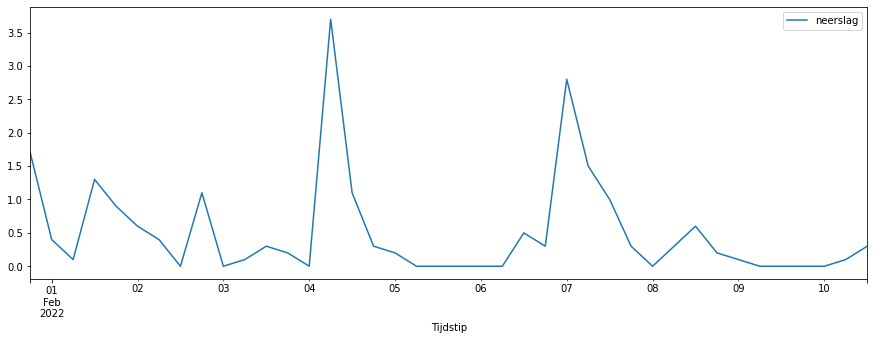

In [2]:
url = 'https://cdn.knmi.nl/knmi/json/page/weer/waarschuwingen_verwachtingen/ensemble/iPluim/380_Expert_13021.json'
r = requests.get(url)
import pprint
for serie in r.json()["series"]:
    if "name" in serie.keys() and serie["name"] == "Hoge resolutie":
        neerslag = pd.DataFrame(serie["data"], columns=["time", "neerslag"])
        
# Omzetten van unix timestamp [ms] naar datetime
neerslag["Tijdstip"] = pd.to_datetime(neerslag["time"], unit="ms")

neerslag.set_index("Tijdstip", inplace=True)
neerslag.drop("time", inplace=True, axis=1)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
neerslag.plot(ax=ax)

## Bewolking

<AxesSubplot:xlabel='Tijdstip'>

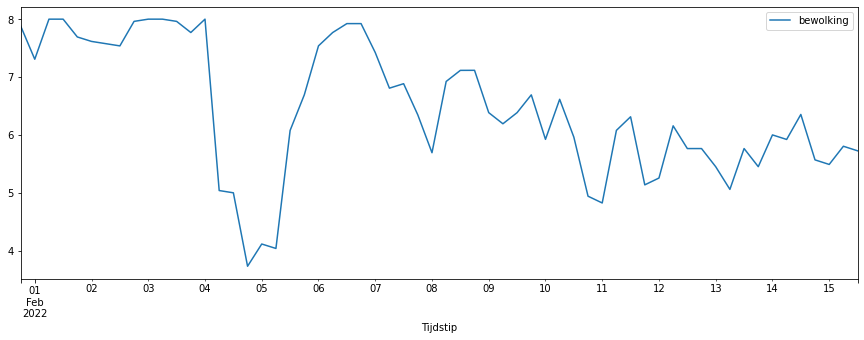

In [3]:
url = 'https://cdn.knmi.nl/knmi/json/page/weer/waarschuwingen_verwachtingen/ensemble/iPluim/380_Expert_20010.json'
r = requests.get(url)
import pprint
# Bewolking wordt anders teruggegeven, meerdere kolommen
for serie in r.json()["series"]:
    #print(serie["name"])
    if serie["name"] == "Onbewolkt": 
        onbewolkt = pd.DataFrame(serie["data"], columns=["time", "onbewolkt"])
    if serie["name"] == "Licht bewolkt": 
        licht_bewolkt = pd.DataFrame(serie["data"], columns=["time", "licht_bewolkt"])
    if serie["name"] == "Half bewolkt": 
        half_bewolkt = pd.DataFrame(serie["data"], columns=["time", "half_bewolkt"])
    if serie["name"] == "Zwaar bewolkt": 
        zwaar_bewolkt = pd.DataFrame(serie["data"], columns=["time", "zwaar_bewolkt"])
    if serie["name"] == "Geheel bewolkt": 
        geheel_bewolkt = pd.DataFrame(serie["data"], columns=["time", "geheel_bewolkt"])

# Alle typen bewolking in één dataframe stoppen        
bewolking = onbewolkt.merge(licht_bewolkt, on="time")
bewolking = bewolking.merge(half_bewolkt, on="time")
bewolking = bewolking.merge(zwaar_bewolkt, on="time")
bewolking = bewolking.merge(geheel_bewolkt, on="time")

# Controle uitvoeren, som = 100%
#bewolking["controle"] = bewolking["onbewolkt"] + bewolking["licht_bewolkt"] + bewolking["half_bewolkt"] + bewolking["zwaar_bewolkt"] + bewolking["geheel_bewolkt"]

# Omzetten timestamp naar tijd (index)
bewolking["Tijdstip"] = pd.to_datetime(bewolking["time"], unit="ms")
bewolking.set_index("Tijdstip", inplace=True)
bewolking.drop("time", inplace=True, axis=1)

# Bewolking score uitrekenen
# Nul keer iets is altijd nul, maar voor leesbaarheid laten staan
bewolking["bewolking"] = (0 * bewolking["onbewolkt"] + 2 * bewolking["licht_bewolkt"] + 4 * bewolking["half_bewolkt"] + 6 * bewolking["zwaar_bewolkt"] + 8 * bewolking["geheel_bewolkt"])/100

# Grafiek tekenen
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
bewolking.plot(y="bewolking", ax=ax)

## Combineren van de weersvoorspelling


In [4]:
# De temperatuur, neerslag en bewolking worden in een dataframe opgeslagen
voorspelling = temperatuur.merge(neerslag, left_index=True, right_index=True)
voorspelling = voorspelling.merge(bewolking["bewolking"], left_index=True, right_index=True)

# Voorspelling opslaan in een SQLite3 database
import sqlite3
conn = sqlite3.connect("voorspelling.db")
cursor = conn.cursor()

# Vorige voorspelling wissen
cursor.execute("DROP TABLE IF EXISTS voorspelling")

# Voorspelling opslaan in database
voorspelling.to_sql("voorspelling", conn)

conn.commit()
conn.close()